# Train a baseline U-Net on the fastMRI dataset

In [40]:
import functools
import itertools
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_mri as tfmri

In [41]:
# Proportion of k-space lines in fully-sampled central region.
fully_sampled_region = 0.08

In [42]:
# If necessary, change the path names here.
fastmri_path = pathlib.Path("/media/storage/fastmri")

data_path_train = fastmri_path / "knee_multicoil_train"
data_path_val = fastmri_path / "knee_multicoil_val"
data_path_test = fastmri_path / "knee_multicoil_test"

In [43]:
files_train = data_path_train.glob("*.h5")
files_val = data_path_val.glob("*.h5")
files_test = data_path_test.glob("*.h5")

In [44]:
# Spec for an element of the fastMRI dataset (the contents of one file).
element_spec = {
    # kspace shape is `[slices, coils, height, width]` as described in
    # https://fastmri.org/dataset/.
    '/kspace': tf.TensorSpec(shape=[None, None, None, None], dtype=tf.complex64),
    # the dataset also contains the root sum-of-squares reconstruction of the
    # multicoil k-space data, with shape `[slices, height, width]` and where
    # `height` and `width` are cropped to 320.
    '/reconstruction_rss': tf.TensorSpec(shape=[None, 320, 320], dtype=tf.float32)
}

def read_hdf5(filename, spec=None):
  """Reads an HDF file into a `dict` of `tf.Tensor`s.

  Args:
    filename: A string, the filename of an HDF5 file.
    spec: A dict of `dataset:tf.TensorSpec` or `dataset:dtype`
      pairs that specify the HDF5 dataset selected and the `tf.TensorSpec`
      or dtype of the dataset. In eager mode the spec is probed
      automatically. In graph mode `spec` has to be specified.
  """
  io_tensor = tfio.IOTensor.from_hdf5(filename, spec=spec)
  tensors = {k: io_tensor(k).to_tensor() for k in io_tensor.keys}
  return {k: tf.ensure_shape(v, spec[k].shape) for k, v in tensors.items()}

def initialize_fastmri_dataset(files):
  """Creates a `tf.data.Dataset` from a list of fastMRI HDF5 files.
  
  Args:
    files: A list of strings, the filenames of the HDF5 files.
    element_spec: The spec of an element of the dataset. See `read_hdf5` for
      more details.
    batch_size: An int, the batch size.
    shuffle: A boolean, whether to shuffle the dataset.
  """
  # Canonicalize `files` as a list of strings.
  files = list(map(str, files))
  if len(files) == 0:
    raise ValueError("no files found")
  # Make a `tf.data.Dataset` from the list of files.
  ds = tf.data.Dataset.from_tensor_slices(files)
  # Read the data in the file.
  ds = ds.map(functools.partial(read_hdf5, spec=element_spec))
  # The first dimension of the inputs is the slice dimension. Split each
  # multi-slice element into multiple single-slice elements, as the
  # reconstruction is performed on a slice-by-slice basis.
  split_slices = lambda x: tf.data.Dataset.from_tensor_slices(x)
  ds = ds.flat_map(split_slices)
  # Remove slashes.
  ds = ds.map(lambda x: {k[1:]: v for k, v in x.items()})
  return ds

In [45]:
ds_train = initialize_fastmri_dataset(files_train)
ds_val = initialize_fastmri_dataset(files_val)
# ds_test = initialize_fastmri_dataset(files_test)

In [46]:
ds_train = ds_train.take(100)
ds_val = ds_val.take(100)

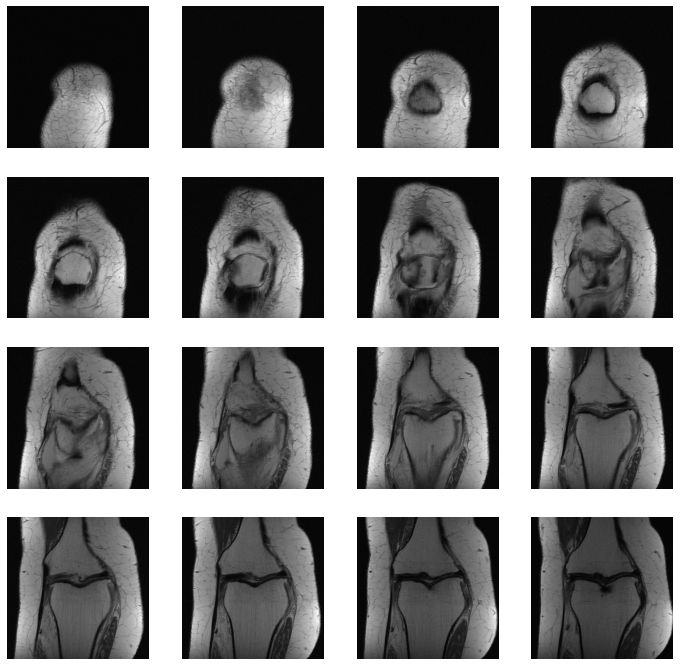

In [47]:
def show_examples(ds, fn, n=16):
  cols = 4
  rows = (n + cols - 1) // cols
  _, axs = plt.subplots(rows, cols, figsize=(12, 3 * rows), squeeze=False)
  if isinstance(ds, tf.data.Dataset):
    ds = ds.take(n)
  else:
    ds = itertools.islice(ds, n)
  for index, example in enumerate(ds):
    i, j = index // cols, index % cols
    axs[i, j].imshow(fn(example), cmap='gray')
    axs[i, j].axis('off')
  plt.show()

display_fn = lambda example: example['reconstruction_rss'].numpy()
show_examples(ds_train, display_fn)

In [28]:
def create_kspace_mask(kspace):
  """Subsamples a fastMRI example (single slice).

  Args:
    ds: A `tf.data.Dataset` object.
  """
  num_lines = tf.shape(kspace)[-1]
  density_1d = tfmri.sampling.density_grid(shape=[num_lines],
                                           inner_density=1.0,
                                           inner_cutoff=0.08,
                                           outer_cutoff=0.08,
                                           outer_density=0.25)
  mask_1d = tfmri.sampling.random_mask(
      shape=[num_lines], density=density_1d)
  mask_2d = tf.broadcast_to(mask_1d, tf.shape(kspace)[-2:])
  return mask_2d
  
def reconstruct_zerofilled(kspace, mask=None, sensitivities=None):
  image_shape = tf.shape(kspace)[-2:]
  image = tfmri.recon.adjoint(kspace, image_shape,
                              mask=mask, sensitivities=sensitivities)
  if sensitivities is None:
    image = tfmri.coils.combine_coils(image, coil_axis=-3)
  return image

def filter_kspace_lowpass(kspace):
  def box(freq):
    cutoff = fully_sampled_region * np.pi
    result = tf.where(tf.math.abs(freq) < cutoff, 1, 0)
    return result
  return tfmri.signal.filter_kspace(kspace, filter_fn=box, filter_rank=1)

def compute_sensitivities(kspace):
  filt_kspace = filter_kspace_lowpass(kspace)
  filt_image = reconstruct_zerofilled(filt_kspace)
  sensitivities = tfmri.coils.estimate_sensitivities(filt_image, coil_axis=-3)
  return sensitivities

def scale_kspace(kspace):
  filt_kspace = filter_kspace_lowpass(kspace)
  filt_image = reconstruct_zerofilled(filt_kspace)
  scale = tf.math.reduce_max(tf.math.abs(filt_image))
  return kspace / tf.cast(scale, kspace.dtype)

In [29]:
def preprocess_fastmri_example(example, training=True):
  # Drop the `reconstruction_rss` element. We will not be using that.
  if 'reconstruction_rss' in example:
    example.pop('reconstruction_rss')

  if training:
    # Crop to 320x320.
    image = tfmri.signal.ifft(example['kspace'], axes=[-2, -1], shift=True)
    image = tfmri.resize_with_crop_or_pad(image, [320, 320])
    example['kspace'] = tfmri.signal.fft(image, axes=[-2, -1], shift=True)

    # Create a subsampling mask.
    example['mask'] = create_kspace_mask(example['kspace'])
    full_kspace = example['kspace']
    example['kspace'] = tf.where(example['mask'], example['kspace'], 0)

    # Create output image from fully sampled k-space.
    full_kspace = scale_kspace(full_kspace)
    image = reconstruct_zerofilled(full_kspace)
    image = tf.expand_dims(image, -1)
    image = tf.math.abs(image)
    example = (example, image)
  return example

ds_train = ds_train.map(preprocess_fastmri_example)
ds_val = ds_val.map(preprocess_fastmri_example)
# ds_test = ds_test.map(functools.partial(preprocess_fastmri_example, training=False))

# display_fn = lambda example: np.abs(example['image'].numpy()[5, ...])
# show_examples(ds_train, display_fn, n=16)

In [30]:
batch_size = 1

ds_train = ds_train.shuffle(buffer_size=10)

def finalize_fastmri_dataset(ds):
  ds = ds.cache()
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

ds_train = finalize_fastmri_dataset(ds_train)
ds_val = finalize_fastmri_dataset(ds_val)
# ds_test = finalize_fastmri_dataset(ds_test, training=False) 

In [31]:
def create_keras_inputs(ds):
  return tf.nest.map_structure(
      lambda x, name: tf.keras.Input(shape=x.shape[1:], dtype=x.dtype, name=name),
      ds.element_spec[0], {k: k for k in ds.element_spec[0].keys()})

inputs = create_keras_inputs(ds_train)

print(inputs)

{'kspace': <KerasTensor: shape=(None, None, 320, 320) dtype=complex64 (created by layer 'kspace')>, 'mask': <KerasTensor: shape=(None, 320, 320) dtype=bool (created by layer 'mask')>}


In [32]:
class AdjointRecon(tf.keras.layers.Layer):
  def __init__(self, magnitude_only=False, **kwargs):
    super().__init__(**kwargs)
    self.magnitude_only = magnitude_only
  
  def call(self, inputs):
    # Scale k-space signal.
    kspace = scale_kspace(inputs['kspace'])
    # Reconstruct image.
    image = reconstruct_zerofilled(kspace, mask=inputs['mask'])
    image = tf.expand_dims(image, -1)
    if self.magnitude_only:
      image = tf.math.abs(image)
    return image

In [33]:
def BaselineUNet(inputs):
  zfill = AdjointRecon(magnitude_only=True, name='zfill')(inputs)
  image = tfmri.models.UNet2D(
      filters=[32, 64, 128],
      kernel_size=3,
      out_channels=1,
      name='image')(zfill)
  outputs = {'zfill': zfill, 'image': image}
  return tf.keras.Model(inputs=inputs, outputs=outputs)

model = BaselineUNet(inputs)

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tfmri.metrics.PSNR(), tfmri.metrics.SSIM()])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 kspace (InputLayer)            [(None, None, 320,   0           []                               
                                320)]                                                             
                                                                                                  
 mask (InputLayer)              [(None, 320, 320)]   0           []                               
                                                                                                  
 zfill (AdjointRecon)           (None, 320, 320, 1)  0           ['kspace[0][0]',                 
                                                                  'mask[0][0]']                   
                                                                                            

In [34]:
# model.fit(ds_train, epochs=10, validation_data=ds_val)

In [36]:
print(preds)

{'zfill': array([[[[0.03730954],
         [0.04248981],
         [0.03511715],
         ...,
         [0.03627022],
         [0.03310308],
         [0.04002528]],

        [[0.04117708],
         [0.02795216],
         [0.03342503],
         ...,
         [0.03422057],
         [0.0305617 ],
         [0.03323219]],

        [[0.03162055],
         [0.03424564],
         [0.04071327],
         ...,
         [0.03863482],
         [0.03950511],
         [0.04508803]],

        ...,

        [[0.03643849],
         [0.03413566],
         [0.03994865],
         ...,
         [0.04486349],
         [0.04716439],
         [0.05293337]],

        [[0.04042355],
         [0.04095628],
         [0.05113396],
         ...,
         [0.03842064],
         [0.05322709],
         [0.04076931]],

        [[0.05052018],
         [0.04702099],
         [0.04676762],
         ...,
         [0.03381801],
         [0.04896087],
         [0.03535406]]],


       [[[0.03114065],
         [0.04702193],
    

In [38]:
preds = model.predict(ds_train.take(30))

30/30 [==============================] - 12s 212ms/step


2022-08-04 09:17:25.761455: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


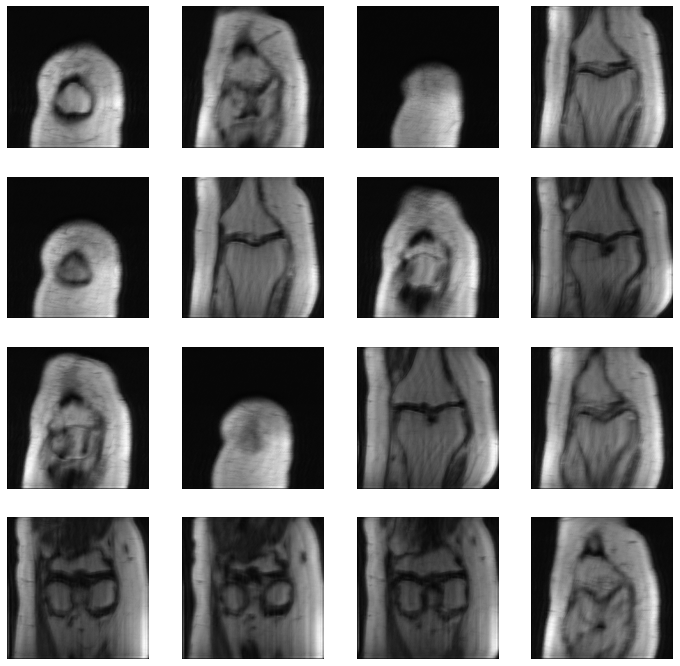

In [49]:
show_examples(preds['image'], lambda x: np.abs(x), n=16)

In [53]:
def VarNet(inputs, num_iterations=5):
  adj = AdjointRecon(name='zfill')
  lsgd = tfmri.layers.LeastSquaresGradientDescent(
      operator=tfmri.linalg.LinearOperatorMRI)
  denoise = tfmri.models.UNet2D(
      filters=[32, 64, 128],
      kernel_size=3,
      activation=tfmri.activations.complex_relu,
      out_channels=1,
      dtype=tf.complex64,
      name='prior')

  zfill = adj(inputs)
  x = zfill
  for i in range(num_iterations):
    x = denoise(x)
    x = lsgd(x)

  outputs = {'zfill': zfill, 'image': x}
  return tf.keras.Model(inputs=inputs, outputs=outputs)

model = VarNet(inputs)

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tfmri.metrics.PSNR(), tfmri.metrics.SSIM()])

model.summary()

AttributeError: module 'tensorflow_mri._api.activations' has no attribute 'complex_relu'